#Autoencoders

##Introducción: 
Un autoencoder es una red neuronal que aprende a como copiar sus entradas a sus salidas, tiene una capa oculta que describe el codigo utilizado para representar la entrada, esta constituido por dos partes principales: un encoder que mapea la entrada hacia el código, y un decodificador que mapea el codigo a la reconstrucción de la entrada.

A continuacion veremos un ejemplo de un Autoencoder.

Importamos las librerias 

In [1]:
import numpy as np  
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt

Definimos los parámetros

In [2]:
#Hyperparameters
#Para la reproducibilidad elegimos random 
np.random.seed(11)
tf.random.set_seed(11)
#para Entrenamiento de autoencoder 
batch_size = 256
max_epochs = 50

learning_rate = 1e-3
momentum = 8e-1
hidden_dim = 128
#reshape de dataset 
original_dim = 784

Tratamos nuestro dataset.

In [3]:
#Importamos dataset de MNIST
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()
#normalizamos los datos, entonces dividimos cada pixel de todos los elementos
#por 255
x_train = x_train / 255.
x_test = x_test / 255.
# Redimensionamos los elementos de una matriz de 28x28 pixeles a un vector de
#784 pixeles 
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))
training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

11493376/11490434 [==============================] - 0s 0us/step


Creación del modelo

In [4]:
#Creamos nuestro modelo de Autoencoder 

#Capa de un encoder 
class Encoder(K.layers.Layer):
    def __init__(self, hidden_dim):         #inicializamos todas entradas independientes
        super(Encoder, self).__init__()
        self.hidden_layer = K.layers.Dense(units=hidden_dim, activation=tf.nn.relu)
        
    #Forward Calculation 
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return activation

Capa de decoder

In [5]:
#Toma las entradas del encoder para reconstruirlas 
class Decoder(K.layers.Layer):
    def __init__(self, hidden_dim, original_dim):
        super(Decoder, self).__init__()
        self.output_layer = K.layers.Dense(units=original_dim, activation=tf.nn.relu)
  
    def call(self, encoded):
        activation = self.output_layer(encoded)
        return activation 

Capa de autoencoder

In [6]:
 class Autoencoder(K.Model):
  #iniciamos la función de perdida 
    def __init__(self, hidden_dim, original_dim):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(hidden_dim=hidden_dim)
        self.decoder = Decoder(hidden_dim=hidden_dim, original_dim=original_dim)
#definimos signal flow 
    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed

Se realiza el Autoencoder 

In [7]:
# función de perdida y optimizadores 
autoencoder = Autoencoder(hidden_dim=hidden_dim, original_dim=original_dim)
opt = tf.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
def loss(preds, real):
    return tf.reduce_mean(tf.square(tf.subtract(preds, real)))
#Vamos a definir nuestra función de entrenamiento 
def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        preds = model(original)
        reconstruction_error = loss(preds, original)
    gradients = tape.gradient(reconstruction_error, model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)
    return reconstruction_error

Entrenamiento 

In [8]:
#Loop de entrenamiento con 50 epochs 
def train_loop(model, opt, loss, dataset, epochs=20):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, batch_features in enumerate(dataset):
            loss_values = train(loss, model, opt, batch_features)
            epoch_loss += loss_values
        model.loss.append(epoch_loss)
        print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

In [9]:
# autoendoer 
autoencoder = Autoencoder(hidden_dim=hidden_dim, original_dim=original_dim)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
# Entrenamos el modelo 
train_loop(autoencoder, opt, loss, training_dataset, epochs=max_epochs)

Epoch 1/50. Loss: 5.159158706665039
Epoch 2/50. Loss: 3.058961868286133
Epoch 3/50. Loss: 2.959378480911255
Epoch 4/50. Loss: 2.8905375003814697
Epoch 5/50. Loss: 2.8556926250457764
Epoch 6/50. Loss: 2.854836940765381
Epoch 7/50. Loss: 2.8206119537353516
Epoch 8/50. Loss: 2.81685733795166
Epoch 9/50. Loss: 2.8408892154693604
Epoch 10/50. Loss: 2.7958579063415527
Epoch 11/50. Loss: 2.8113434314727783
Epoch 12/50. Loss: 2.8162360191345215
Epoch 13/50. Loss: 2.7962427139282227
Epoch 14/50. Loss: 2.795917272567749
Epoch 15/50. Loss: 2.784165382385254
Epoch 16/50. Loss: 2.8147096633911133
Epoch 17/50. Loss: 2.7829976081848145
Epoch 18/50. Loss: 2.803821325302124
Epoch 19/50. Loss: 2.7968344688415527
Epoch 20/50. Loss: 2.7952380180358887
Epoch 21/50. Loss: 2.79506254196167
Epoch 22/50. Loss: 2.7881031036376953
Epoch 23/50. Loss: 2.803673505783081
Epoch 24/50. Loss: 2.7880311012268066
Epoch 25/50. Loss: 2.7936599254608154
Epoch 26/50. Loss: 2.7788949012756348
Epoch 27/50. Loss: 2.812021017074

Gráfica del comportamiento del modelo 

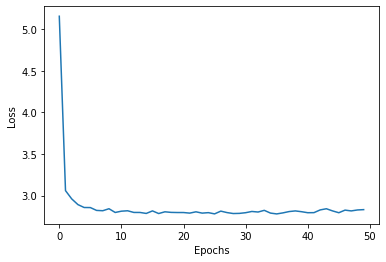

In [10]:

plt.plot(range(max_epochs), autoencoder.loss)
plt.xlabel('Epochs')      #eje X
plt.ylabel('Loss')        #eje y 
plt.show()

Visualización 

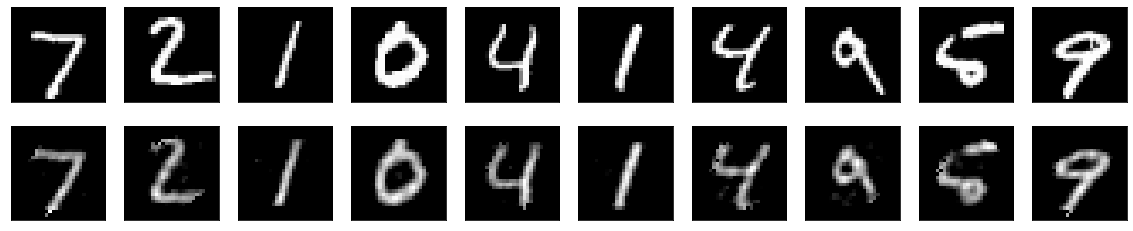

In [11]:
#visualización de las imagenes originales y la reconstrucción por medio del autoencoder 
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
  #imágenes originales 
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#imágenes reconstruidas 
    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test)[index].numpy().reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()